## Supervised Learning: Classification. Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# import various metrics for model scoring
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Motivation for Logistic Regression

### What is classification?

A large family of supervised learning algorithms where the label (a.k.a., output, dependent variable, predicted variable...) is categorical. Examples: fraud detection, medical diagnostics, yes/no decisions, image classification etc.


### Can we solve a classification problem using Linear Regression?

#### Example: simplified credit approvals dataset
- Variables: Credit_Score (int) and Approval (label, categorical)
- Problem statement: predict credit approval decision from the credit score

In [2]:
df = pd.read_csv("https://github.com/wsko/data_science_academy/raw/main/data/Credit_Approvals.csv")
print(df.head())
df = df.sort_values('Credit_Score', ignore_index=True) ## ordering is important for visualization with line plots

   Credit_Score  Approval
0           329         0
1           780         1
2           374         0
3           938         1
4           705         1


#### Credit score conditional distributions for credit approval / rejection 
- What statistical tests can you perform to decide if you want to proceed with predictive modeling?

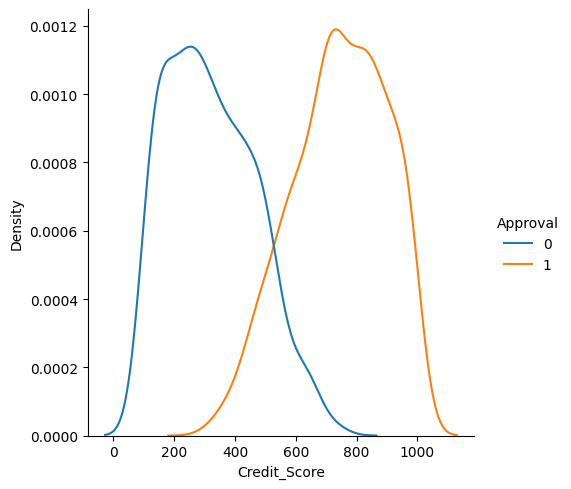

In [3]:
sns.displot(data = df, x = "Credit_Score", hue = "Approval", kind = 'kde')
plt.show()

#### Let's try modeling this dataset with Linear Regression (OLS and SGD)

MSE =   0.08367628062706593


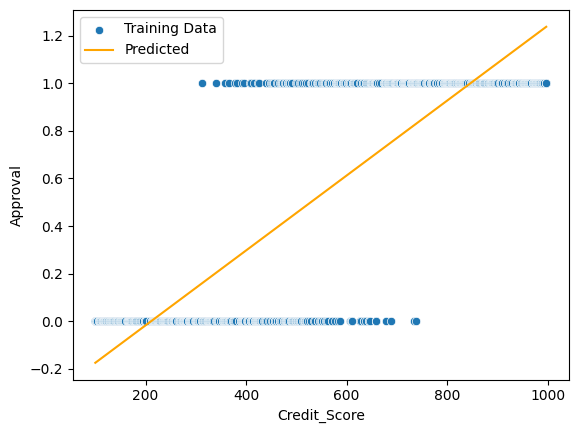

In [4]:
X = df[['Credit_Score']].to_numpy()
y = df['Approval'].to_numpy()

ols = LinearRegression()
ols.fit(X, y)

df['Approval_predicted'] = ols.predict(X)

ax = sns.scatterplot(data = df, x = 'Credit_Score', y = 'Approval', label = 'Training Data')
ax = sns.lineplot(data = df, x = 'Credit_Score', y = 'Approval_predicted', label = "Predicted", color = 'orange')

print("MSE =  ", mean_squared_error(y, ols.predict(X)))

##### is this a good predictive model?

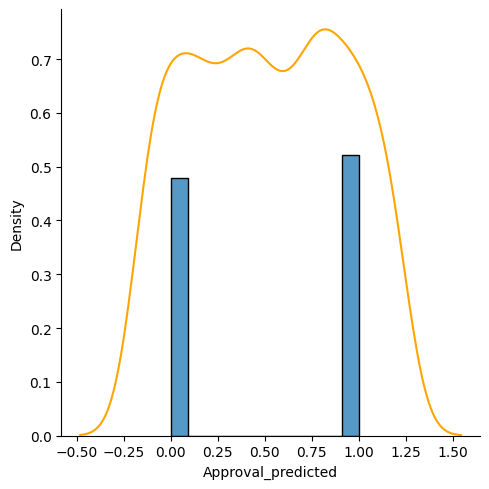

In [5]:
ax = sns.displot(df['Approval_predicted'], kind = 'kde', label = "Predicted", color = 'orange')
ax = sns.histplot(df['Approval'],label = "Training Data", stat = 'probability')

#### Better approach:

- The distributuions of the predicted and known label values are distinctly different
- Step function would work but it is not differentiable (and we need gradients)
- Represent the predicted binary label (0, 1) as a continuous variable using the Sigmoid function

https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

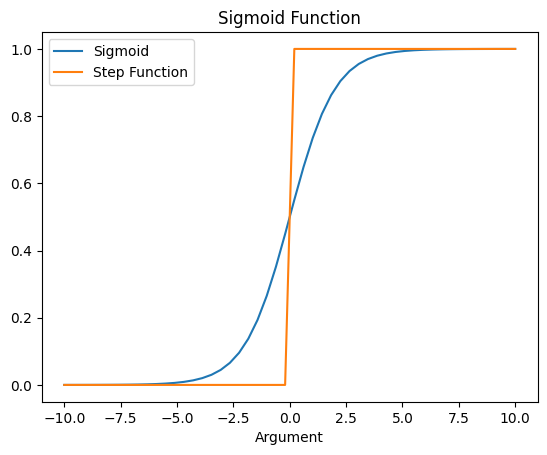

In [6]:
z = np.linspace(-10, 10)
Step = (np.sign(z) + 1)/2
Sigmoid = 1 / (1 + np.exp(-z))
ax = sns.lineplot(x = z, y = Sigmoid, label = "Sigmoid")
ax = sns.lineplot(x = z, y = Step, label = "Step Function")
ax.set_title("Sigmoid Function")
ax.set_xlabel("Argument")
plt.show()

### Logistic Regression

- Supervised learning algorithm for predicting a categorical label
- The argument _z_ of the sigmnoid function is a linear function of the features
- This is a generalized linear model: very much like linear regression except the linear equation is pluuged into a non-linear activation function (sigmoid)

In [7]:
logr = LogisticRegression()
logr.fit(X, y)
print("MSE:  ", mean_squared_error(y, logr.predict(X)))
print("Log Loss  :", log_loss(y, logr.predict(X)))

## we cannot use MSE as a loss function because it makes gradient descent unstable
## Use LogLoss instead

MSE:   0.092
Log Loss  : 3.177601811021282


#### Math expression for Log Loss

$$L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$$

where:

$$p = \operatorname{Pr}(y = 1)$$

In [8]:
## model parameters:

(logr.intercept_, logr.coef_)

(array([-8.6938958]), array([[0.0166077]]))

__`LogisticRegression()` has two predict methods__:
- Predict binary values (1 or 0)
- Predict Probabilities (the values of trhe Sigmoid function)
- LR uses Threshold to convert Sigmoid values to Binary values
    - Sigmoid values above the threshold predict Category = 1
    - Sigmoid values below the threshold predict Category = 0

In [9]:
df["Predicted"] = logr.predict(X)
df["Sigmoid"] = logr.predict_proba(X)[:,1]

In [10]:
df.tail(10)

,Credit_Score,Approval,Approval_predicted,Predicted,Sigmoid
990,988,1,1.223476,1,0.999554
991,988,1,1.223476,1,0.999554
992,989,1,1.225051,1,0.999561
993,991,1,1.228199,1,0.999576
994,992,1,1.229774,1,0.999583
995,993,1,1.231348,1,0.999589
996,996,1,1.236071,1,0.999609
997,996,1,1.236071,1,0.999609
998,996,1,1.236071,1,0.999609
999,997,1,1.237645,1,0.999616


Text(0, 0.5, 'Approval')

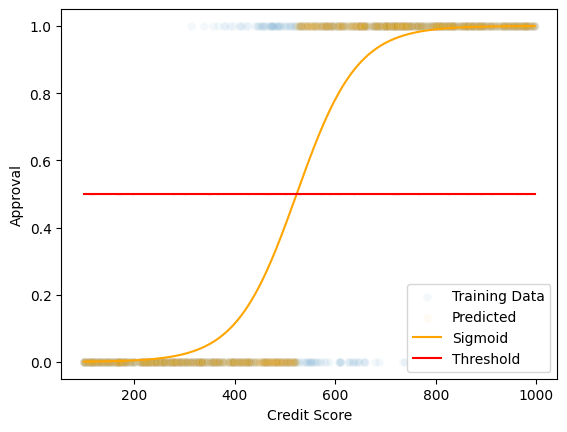

In [11]:
ax = sns.scatterplot(data = df, x = 'Credit_Score', y = 'Approval', label = 'Training Data', alpha = 0.05)
ax = sns.scatterplot(data = df, x = 'Credit_Score', y = 'Predicted', label = "Predicted", color = 'orange', alpha = 0.05)
ax = sns.lineplot(data = df, x = 'Credit_Score', y = 'Sigmoid', color = 'orange', label = "Sigmoid")
df['threshold'] = 0.5
ax = sns.lineplot(data = df, x = 'Credit_Score', y = 'threshold', color = 'red', label = "Threshold")
ax.set_xlabel("Credit Score")
ax.set_ylabel("Approval")

### Classifier evaluation metrics

- MSE can still be computed mathematically but is not an efficient score for classifiers 
- __Accuracy__ is an easy metric to compute and understand: the ratio of correct to total predictions

In [12]:
accuracy_score(y, logr.predict(X))

0.908

In [13]:
(y == logr.predict(X)).mean()

0.908

- For more granular classifier scoring, we will use the confusion matrix to count correct and incorrect predictions on Class 0 and Class 1, separately
- What is Confusion Matrix?
    - Crosstab between predicted and actual values for each class
    
<img src="https://github.com/wsko/data_science_academy/blob/main/images/confusion_matrix.png?raw=true" alt="Confusion Matrix" width="600" height="600">

In [14]:
confusion_matrix(y, logr.predict(X))

array([[436,  43],
       [ 49, 472]], dtype=int64)

In [15]:
print(classification_report(y, logr.predict(X), target_names = ['Rejected', 'Approved'])[:220]) ##classification_report returns a string

              precision    recall  f1-score   support

    Rejected       0.90      0.91      0.90       479
    Approved       0.92      0.91      0.91       521

    accuracy                           0.91      1000
  


### Decision Boundary

- What is the meaning of the linear function which we are plugging into the sigmoid?
- Let's build a logistic regression model using the Iris dataset and...
- Compute the decision boundary from model coefficients: $C_0 + C_1x_1 + C_2x_2 = 0$

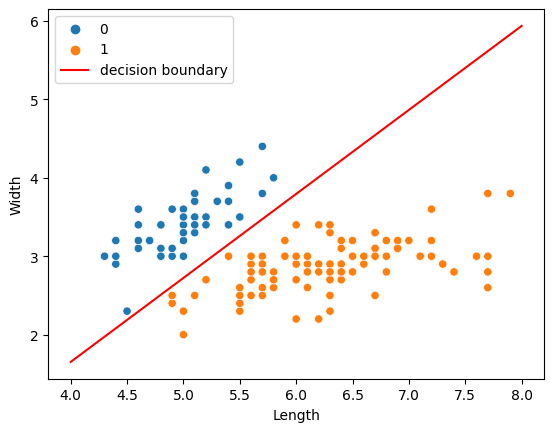

In [16]:
dfi = pd.read_csv("https://github.com/wsko/data_science_academy/raw/main/data/iris_mod.csv")
X = dfi.iloc[:, :2].values
y = dfi.iloc[:, 2].values
lrm = LogisticRegression()
lrm.fit(X, y)
xx = np.array([4, 8])
yy = - (xx * lrm.coef_[0][0] + lrm.intercept_)/lrm.coef_[0][1]
ax = sns.scatterplot(x = "Length", y = "Width", hue = "Species", data = dfi)
ax = sns.lineplot(x = xx, y = yy, color = 'red', label = 'decision boundary')

In [17]:
dfi

,Length,Width,Species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,1
146,6.3,2.5,1
147,6.5,3.0,1
148,6.2,3.4,1


### A "Real-world" example

#### Kaggle Titanic dataset competition

" On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships. One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others... "

https://www.kaggle.com/competitions/titanic/data

##### Data Dictionary
__Variable, Definition and Key__
- survival:	Survival	0 = No, 1 = Yes
- pclass:	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex:	Sex	
- Age:	Age in years	
- sibsp:	# of siblings / spouses aboard the Titanic	
- parch:	# of parents / children aboard the Titanic	
- ticket:	Ticket number	
- fare:	Passenger fare	
- cabin:	Cabin number	
- embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [18]:
df = pd.read_csv("https://github.com/wsko/data_science_academy/raw/main/data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
df['Age'] = df['Age'].fillna(df['Age'].mean())
df = pd.get_dummies(df, drop_first=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


- Build data arrays
- Perform train-test split
- Feature scaling

In [22]:
X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()
features = list(df.iloc[:, 1:].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
#min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
## train a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

##### Let'as score our model on the test set

In [24]:
print(classification_report(y_test, lr.predict(X_test), 
                            target_names = ['Died', 'Survived'])[:220]) 


pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)), 
                              index = ['Died', 'Survived'], 
             columns = ["Died predicted","Survived predicted"])

              precision    recall  f1-score   support

        Died       0.81      0.86      0.84       157
    Survived       0.78      0.72      0.75       111

    accuracy                           0.80       268
  


,Died predicted,Survived predicted
Died,135,22
Survived,31,80


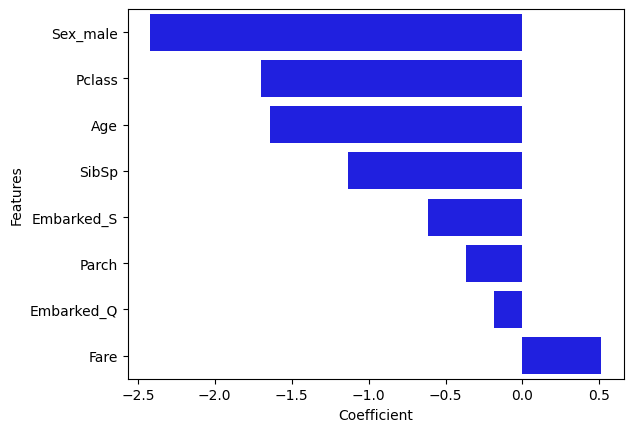

In [25]:
coefficients = pd.DataFrame({'Features': features, 'Coefficient': lr.coef_[0]})
sns.barplot(data = coefficients.sort_values('Coefficient'), y = 'Features', x = 'Coefficient', color = 'blue')
plt.show()

## Your Turn: Lab 5, Part 1

## Imbalanced Data

#### Accuracy is not an efficient metric when your data is _imbalanced_. Fraud detection example:
- There are much fewer examples of fraud transactions than regular transaction
- Also think about medical diagnostics, system fault detection etc.
- Imbalanced datasets are challenging: they tend to predict well the dominating class but not the minor class

In [26]:
df1 = pd.read_csv("https://github.com/wsko/data_science_academy/raw/main/data/Fraud_Detection_kaggle.csv")
## This dataset is large. We will look at a 1% sample to prevent seaborn delays
df1 = df1.sample(random_state=42, frac=0.05, ignore_index=True)
df1.describe()

,amount,fraud
count,29732.000000,29732.000000
mean,37.490727,0.011839
std,106.895710,0.108163
min,0.000000,0.000000
25%,13.810000,0.000000
50%,26.770000,0.000000
75%,42.190000,0.000000
max,7134.390000,1.000000


- How many fraud and non-fraud examples fdo we have?

In [27]:
df1['fraud'].value_counts()

0    29380
1      352
Name: fraud, dtype: int64

In [28]:
X = df1[['amount']].values
y = df1['fraud'].values

logr = LogisticRegression()
logr.fit(X, y)

y_pred = logr.predict(X)
accuracy_score(y, y_pred)

0.9942822548096327

In [29]:
pd.DataFrame(confusion_matrix(y, y_pred), index = ["No fraud", "Fraud"], columns = ["No fraud predicted","Fraud predicted"])

,No fraud predicted,Fraud predicted
No fraud,29357,23
Fraud,147,205


- The overall accuracy is > 0.99, however....
- Out of a total of 68 fraud examples, only 38 were predicted correctly. This is called model recall

In [30]:
print(classification_report(y, y_pred, target_names = ['No fraud', 'Fraud'])[:220]) ##classification_report returns a string

              precision    recall  f1-score   support

    No fraud       1.00      1.00      1.00     29380
       Fraud       0.90      0.58      0.71       352

    accuracy                           0.99     29732
  


In [31]:
threshold = 0.01 # try 0.01?
y_pred_thr = (logr.predict_proba(X)[:, 1] > threshold).astype('int')

print(classification_report(y, y_pred_thr, target_names = ['No fraud', 'Fraud'])[:220])
pd.DataFrame(confusion_matrix(y, y_pred_thr), index = ["No fraud", "Fraud"], columns = ["No fraud predicted","Fraud predicted"])

              precision    recall  f1-score   support

    No fraud       1.00      0.97      0.98     29380
       Fraud       0.25      0.86      0.39       352

    accuracy                           0.97     29732
  


,No fraud predicted,Fraud predicted
No fraud,28489,891
Fraud,50,302


#### Precision and Recall: important for imbalanced data, typically trade off dependingf on the threshold

- Higher precision (threshold close to 1) means that when fraud cases are predicted as Fraud, the prediction is more accurate. However more fraud cases are not recognized as Fraud
- Higher recall (threshold close to 0) means that an algorithm returns most of the fraud cases are predicted as Fraud, some non-fraud cases are also recognized as Fraud
- How to optimize for precision or recall? Think about __the cost of a wrong prediction__ (error types I and II)

## Your Turn: Lab 5, Part 2